# Part 1 - MNIST

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [11]:
! [ ! -z "$COLAB_GPU" ] && pip install scikit-learn==0.21.* skorch

## Explore data

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from urllib import request

In [2]:
def download_mnist(dataset_dir=Path('data')):
    dataset_dir.mkdir(exist_ok=True)
    mnist_data = dataset_dir / 'mnist.npz'
    url = 'https://github.com/thomasjpfan/pydata2018_dc_skorch/blob/master/data/mnist.npz?raw=true'
    if not mnist_data.exists():
        print("Starting to download data...")
        data = request.urlopen(url, timeout=15).read()
        with open(mnist_data, 'wb') as f:
            f.write(data)
    print("Data has been downloaded to {}.".format(dataset_dir))
    
download_mnist()

Data has been downloaded to data.


In [3]:
mnist = np.load('data/mnist.npz', allow_pickle=True)

In [4]:
X = mnist['data'].astype('float32')
y = mnist['target'].astype('int64')

print(X.shape, y.shape)

(70000, 784) (70000,)


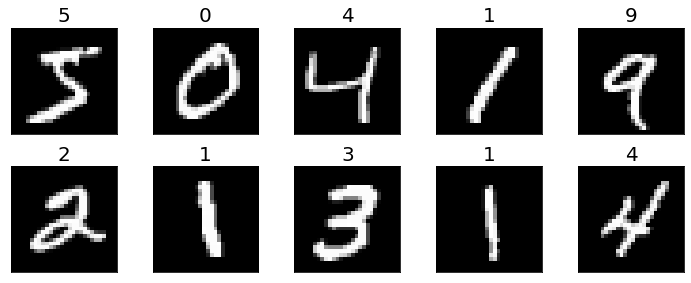

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.patch.set_alpha(0)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(y[idx], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('images/mnist_example.png')

## Simple Neutral Model

In [6]:
import torch.nn as nn

class SimpleFeedforward(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.module = nn.Sequential(
            nn.Linear(784, 98),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(98, 10)
        )
    def forward(self, X):
        return self.module(X)

In [7]:
from sklearn.model_selection import train_test_split

X_scaled = X / X.max()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42)

In [8]:
from skorch import NeuralNet

net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda', # comment out to run on cpu
)

In [9]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5761        0.3123  0.9996
      2        0.3196        0.2344  0.9697
      3        0.2647        0.1972  0.9876
      4        0.2389        0.2024  0.9934
      5        0.2195        0.2008  0.9707
      6        0.2072        0.1413  0.9703
      7        0.1940        0.1339  0.9606
      8        0.1831        0.1229  0.9561
      9        0.1777        0.1286  0.9517
     10        0.1709        0.1175  0.9466


In [10]:
net.set_params(max_epochs=5)
_ = net.partial_fit(X_train, y_train)

     11        0.1665        0.1163  0.9129
     12        0.1596        0.1118  0.9725
     13        0.1563        0.1092  0.9247
     14        0.1503        0.1118  0.9273
     15        0.1481        0.1113  0.9192


## History

In [10]:
len(net.history)

15

In [11]:
net.history[-1, 'valid_loss']

0.12197566009703137

In [12]:
net.history[-2:, 'train_loss']

[0.15320565857206073, 0.15345378470420837]

## Callbacks

### EpochScoring

In [13]:
y_pred = net.predict(X_test)
print(y_pred.shape)
print(y_pred[0, :])

(17500, 10)
[ -3.7149053   -3.4425774    4.2277       6.454636   -11.068788
   2.8243313   -4.5492096   -2.9567776   11.11874     -0.02089611]


In [14]:
def accuracy_argmax(y_true, y_pred):
    return np.mean(y_true == np.argmax(y_pred, -1))

print('test accuracy:', accuracy_argmax(y_test, y_pred))

test accuracy: 0.9633142857142857


In [15]:
from sklearn.metrics import make_scorer
from skorch.callbacks import EpochScoring

accuracy_argmax_scorer = make_scorer(accuracy_argmax)

epoch_acc = EpochScoring(
    accuracy_argmax_scorer,
    name='valid_acc',
    lower_is_better=False)

In [16]:
net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
#     device='cuda',
    callbacks=[epoch_acc]
)

In [17]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5808       0.9040        0.3144  0.9474
      2        0.3254       0.9222        0.2463  0.8968
      3        0.2712       0.9461        0.1809  0.9257
      4        0.2420       0.9487        0.1680  0.8892
      5        0.2228       0.9541        0.1490  0.8933
      6        0.2074       0.9542        0.1514  0.9008
      7        0.1930       0.9596        0.1358  0.9133
      8        0.1868       0.9597        0.1324  0.8976
      9        0.1775       0.9604        0.1298  0.8981
     10        0.1712       0.9593        0.1324  0.9096


## Integration with sklearn

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [19]:
pipe = Pipeline([
    ('min_max', MinMaxScaler()),
    ('net', net)
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
_ = pipe.fit(X_train, y_train)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5701       0.8763        0.3773  0.9347
      2        0.3182       0.9314        0.2214  0.9780
      3        0.2637       0.9391        0.1967  0.9734
      4        0.2357       0.9514        0.1582  1.0441
      5        0.2216       0.9536        0.1508  0.9533
      6        0.2012       0.9560        0.1449  0.9606
      7        0.1928       0.9576        0.1348  0.9549
      8        0.1832       0.9569        0.1366  0.9282
      9        0.1762       0.9612        0.1210  1.0296
     10        0.1701       0.9572        0.1357  0.9059


In [21]:
from sklearn.model_selection import GridSearchCV

pipe.set_params(net__verbose=0)
param_grid = {
    'net__module__dropout': [0.2, 0.5, 0.8]
}

gs = GridSearchCV(pipe, param_grid, 
                  scoring=accuracy_argmax_scorer, 
                  cv=3, verbose=3)

In [22]:
_ = gs.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ net__module__dropout=0.2, score=0.968, total=  11.0s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV] ............ net__module__dropout=0.2, score=0.964, total=  10.7s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s


[CV] ............ net__module__dropout=0.2, score=0.969, total=  11.8s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.962, total=  10.6s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.958, total=  10.3s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.966, total=  11.1s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.939, total=  11.3s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.931, total=  11.2s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.943, total=  10.8s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min finished


In [24]:
print("best score:", gs.best_score_)
print("best_params", gs.best_params_)

best score: 0.9673
best_params {'net__module__dropout': 0.2}
